0) IMPORT ทุกอย่างที่ต้องใช้

In [ ]:
import os
import time
import copy

import numpy as np
import pandas as pd
import cv2
from PIL import Image

import kagglehub   # ใช้โหลด dataset จาก Kaggle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

# ใช้ GPU ถ้ามี ไม่มีก็ใช้ CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

1) ดาวน์โหลด Kaggle Dataset ด้วย kagglehub

In [ ]:
dataset_root = kagglehub.dataset_download('aryashah2k/breast-ultrasound-images-dataset')
print("Kaggle dataset root:", dataset_root)
print("Root content:", os.listdir(dataset_root))

def find_busi_folder(root):
    """
    หาโฟลเดอร์ที่มี benign / malignant / normal อยู่ข้างใน
    หรือโฟลเดอร์ชื่อ Dataset_BUSI_with_GT แบบอัตโนมัติ
    """
    entries = os.listdir(root)

    # กรณีเจอ Dataset_BUSI_with_GT ตรง ๆ
    if "Dataset_BUSI_with_GT" in entries:
        return os.path.join(root, "Dataset_BUSI_with_GT")

    # กรณี root มีโฟลเดอร์ benign/malignant/normal เลย
    if all(x in entries for x in ["benign", "malignant", "normal"]):
        return root

    # ลองมองลงไป 1 ชั้น
    for name in entries:
        path = os.path.join(root, name)
        if os.path.isdir(path):
            sub = os.listdir(path)
            if "Dataset_BUSI_with_GT" in sub:
                return os.path.join(path, "Dataset_BUSI_with_GT")
            if all(x in sub for x in ["benign", "malignant", "normal"]):
                return path

    raise RuntimeError(
        f"ไม่พบโฟลเดอร์ที่มี benign/malignant/normal หรือ Dataset_BUSI_with_GT ใน {root}"
    )

folder_name = find_busi_folder(dataset_root)
print("Using BUSI folder:", folder_name)
print("Class folders:", os.listdir(folder_name))

2) CONFIG: ชื่อคลาส

In [ ]:
# mapping: 0=benign, 1=malignant, 2=normal
class_names = ['benign', 'malignant', 'normal']
num_classes = len(class_names)

3) สร้าง DataFrame รายการรูป

In [ ]:
data = []
for idx, cls in enumerate(class_names):
    class_dir = os.path.join(folder_name, cls)
    print(f"Scanning class: {cls} ({idx}) from {class_dir}")

    for img_name in os.listdir(class_dir):
        # ข้ามไฟล์ mask
        if 'mask' in img_name.lower():
            continue

        img_path = os.path.join(class_dir, img_name)
        data.append({"path": img_path, "label": idx})

df = pd.DataFrame(data)
print(df.head())
print("Total images:", len(df))

4) แบ่ง train / val / test (70 / 15 / 15)

In [ ]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,              # 30% แบ่งไปเป็น val+test
    random_state=42,
    stratify=df["label"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,              # ครึ่งหนึ่งเป็น test ที่เหลือเป็น val
    random_state=42,
    stratify=temp_df["label"]
)

print("Train size:", len(train_df))
print("Val size  :", len(val_df))
print("Test size :", len(test_df))

5) คำนวณ class weight (boost malignant เพิ่ม)

In [ ]:
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)

# label mapping: 0=benign, 1=malignant, 2=normal
boost_factor = 1.5  # เน้น malignant เพิ่ม
class_weights_np[1] *= boost_factor

print("Adjusted class weights:", class_weights_np)

class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)

6) Preprocess + Transform (CLAHE + 3-channel + stronger augment)

In [ ]:
IMG_SIZE_PT = 224   # ขนาดภาพสำหรับ ResNet18

def preprocess_gray_to_rgb(path, img_size=IMG_SIZE_PT):
    """
    อ่านภาพเป็น grayscale -> CLAHE -> resize -> แปลงเป็น 3-channel -> PIL Image
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")

    # CLAHE เพิ่ม contrast (เหมือนที่ใช้ในไฟล์แรก)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Resize
    img = cv2.resize(img, (img_size, img_size))

    # ทำเป็น 3-channel (H,W) -> (H,W,3)
    img_3ch = np.stack([img, img, img], axis=-1)

    # แปลงเป็น PIL Image เพื่อใช้กับ torchvision.transforms
    return Image.fromarray(img_3ch)

def get_transform(split="train"):
    """
    สร้าง transform สำหรับ train / val / test
    """
    if split == "train":
        return transforms.Compose([
            transforms.Resize((IMG_SIZE_PT, IMG_SIZE_PT)),
            transforms.RandomResizedCrop(
                IMG_SIZE_PT,
                scale=(0.9, 1.0),
                ratio=(0.9, 1.1)
            ),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(
                brightness=0.1,
                contrast=0.1
            ),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]
            ),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((IMG_SIZE_PT, IMG_SIZE_PT)),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]
            ),
        ])

7) Dataset / DataLoader

In [ ]:
class UltrasoundDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = preprocess_gray_to_rgb(row["path"])
        if self.transform is not None:
            img = self.transform(img)
        label = int(row["label"])
        return {"image": img, "label": label}

BATCH_SIZE_PT = 32

train_dataset = UltrasoundDataset(train_df, transform=get_transform("train"))
val_dataset   = UltrasoundDataset(val_df,   transform=get_transform("val"))
test_dataset  = UltrasoundDataset(test_df,  transform=get_transform("val"))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_PT, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE_PT, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE_PT, shuffle=False)

dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset),
}

print("Dataloaders ready.")

8) สร้างโมเดล ResNet18 (Transfer Learning)

In [ ]:
# ถ้า pretrained=True แล้ว error เรื่องโหลด weights (ไม่มีเน็ต) ให้เปลี่ยนเป็น pretrained=False
model_pt = models.resnet18(pretrained=True)

# แทนที่ชั้น fc ให้รองรับ 3 class
num_features = model_pt.fc.in_features
model_pt.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

model_pt = model_pt.to(device)
print(model_pt.fc)

criterion = nn.CrossEntropyLoss(weight=class_weights)

9) ฟังก์ชันเทรนโมเดล (รองรับ scheduler + early stopping)

In [ ]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes,
                num_epochs=10, scheduler=None, patience_es=5, phase_name=""):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")
    best_val_acc = 0.0
    bad_epochs = 0

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    print(f"\n===== Start training {phase_name} for {num_epochs} epochs =====\n")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch in dataloaders[phase]:
                inputs = batch["image"].to(device, dtype=torch.float)
                labels = batch["label"].to(device, dtype=torch.long)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            if phase == 'val':
                # ปรับ LR ตาม val loss
                if scheduler is not None:
                    scheduler.step(epoch_loss)

                # เช็ค best model ตาม val loss
                if epoch_loss < best_val_loss - 1e-4:
                    best_val_loss = epoch_loss
                    best_val_acc = epoch_acc
                    bad_epochs = 0
                    best_model_wts = copy.deepcopy(model.state_dict())
                else:
                    bad_epochs += 1

        print(f"Bad epochs (no val improvement): {bad_epochs}\n")

        if bad_epochs >= patience_es:
            print("Early stopping triggered!")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}  Best val Acc: {:.4f}'.format(best_val_loss, best_val_acc))

    model.load_state_dict(best_model_wts)
    return model, history

10) Phase 1 – train เฉพาะ fc

In [ ]:
# Freeze ทุกอย่างยกเว้น fc
for name, param in model_pt.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

optimizer_phase1 = optim.Adam(
    filter(lambda p: p.requires_grad, model_pt.parameters()),
    lr=1e-3
)

NUM_EPOCHS_PHASE1 = 8

model_pt, history1 = train_model(
    model_pt,
    criterion,
    optimizer_phase1,
    dataloaders,
    dataset_sizes,
    num_epochs=NUM_EPOCHS_PHASE1,
    scheduler=None,
    patience_es=4,
    phase_name="Phase 1 (fc only)"
)

11) Phase 2 – unfreeze layer4 + fc แล้ว fine-tune

In [ ]:
for name, param in model_pt.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer_phase2 = optim.Adam(
    filter(lambda p: p.requires_grad, model_pt.parameters()),
    lr=1e-4
)

# ลบ verbose=True ออก เพราะเวอร์ชันนี้ไม่รองรับ
scheduler_phase2 = ReduceLROnPlateau(
    optimizer_phase2,
    mode='min',
    factor=0.5,
    patience=2
)

NUM_EPOCHS_PHASE2 = 12

model_pt, history2 = train_model(
    model_pt,
    criterion,
    optimizer_phase2,
    dataloaders,
    dataset_sizes,
    num_epochs=NUM_EPOCHS_PHASE2,
    scheduler=scheduler_phase2,
    patience_es=5,
    phase_name="Phase 2 (layer4 + fc)"
)

best_model_pt = model_pt

12) Plot learning curve (optional)

In [ ]:
def plot_history(h1, h2, title_suffix=""):
    train_loss = h1["train_loss"] + h2["train_loss"]
    val_loss   = h1["val_loss"]   + h2["val_loss"]
    train_acc  = h1["train_acc"]  + h2["train_acc"]
    val_acc    = h1["val_acc"]    + h2["val_acc"]

    epochs = range(1, len(train_loss)+1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label="train")
    plt.plot(epochs, val_loss, label="val")
    plt.title(f"Loss {title_suffix}")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label="train")
    plt.plot(epochs, val_acc, label="val")
    plt.title(f"Accuracy {title_suffix}")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history1, history2, title_suffix="(Phase1+2)")

13) Evaluate บน Test set

Device: cpu
Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Kaggle dataset root: /kaggle/input/breast-ultrasound-images-dataset
Root content: ['Dataset_BUSI_with_GT']
Using BUSI folder: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT
Class folders: ['benign', 'normal', 'malignant']
Scanning class: benign (0) from /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign
Scanning class: malignant (1) from /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant
Scanning class: normal (2) from /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal
                                                path  label
0  /kaggle/input/breast-ultrasound-images-dataset...      0
1  /kaggle/input/breast-ultrasound-images-dataset...      0
2  /kaggle/input/breast-ultrasound-images-dataset...      0
3  /kaggle/input/breast-ultrasound-images-dataset...      0
4  /kaggle/input/breast-ultraso

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=512, out_features=3, bias=True)
)

===== Start training Phase 1 (fc only) for 8 epochs =====

Epoch 1/8
--------------------
train Loss: 0.9774 Acc: 0.5000
val Loss: 1.1377 Acc: 0.5726
Bad epochs (no val improvement): 0

Epoch 2/8
--------------------
train Loss: 0.8040 Acc: 0.6099
val Loss: 1.1476 Acc: 0.6410
Bad epochs (no val improvement): 1

Epoch 3/8
--------------------
train Loss: 0.7267 Acc: 0.6209
val Loss: 0.7193 Acc: 0.7265
Bad epochs (no val improvement): 0

Epoch 4/8
--------------------
train Loss: 0.7090 Acc: 0.6227
val Loss: 0.8817 Acc: 0.5641
Bad epochs (no val improvement): 1

Epoch 5/8
--------------------
train Loss: 0.6938 Acc: 0.6245
val Loss: 0.7301 Acc: 0.6325
Bad epochs (no val improvement): 2

Epoch 6/8
--------------------
tra

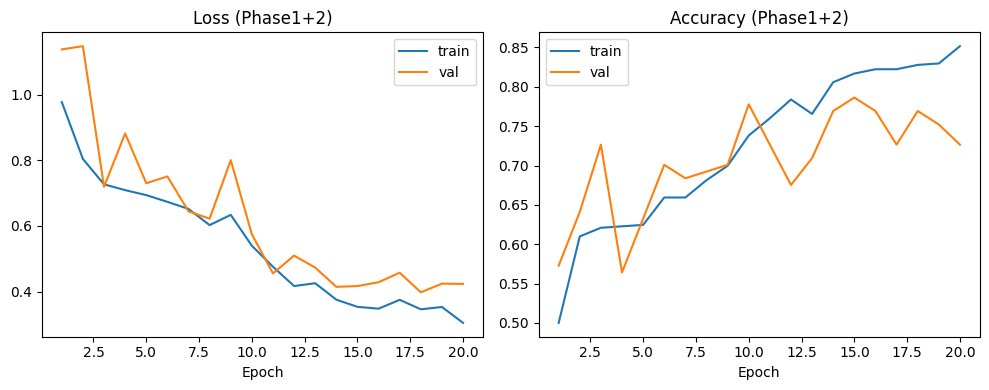


=== Test Metrics (ResNet18, 2-phase fine-tune) ===
Test Accuracy       : 0.7094
Macro F1-score      : 0.7151
Macro Recall        : 0.7649
Macro AUC (OvR)     : 0.8774

Classification report (ResNet18, 2-phase):
              precision    recall  f1-score   support

      benign       0.87      0.61      0.71        66
   malignant       0.57      0.84      0.68        31
      normal       0.68      0.85      0.76        20

    accuracy                           0.71       117
   macro avg       0.70      0.76      0.72       117
weighted avg       0.76      0.71      0.71       117

Confusion Matrix:
 [[40 18  8]
 [ 5 26  0]
 [ 1  2 17]]


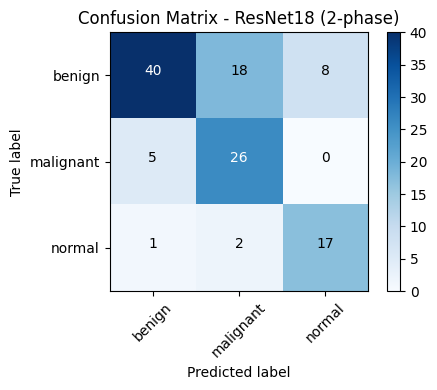

In [ ]:
best_model_pt.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch["image"].to(device, dtype=torch.float)
        labels = batch["label"].to(device, dtype=torch.long)

        outputs = best_model_pt(inputs)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_pred_proba = np.concatenate(all_probs, axis=0)   # (N, num_classes)
y_test_int   = np.concatenate(all_labels, axis=0)  # (N,)
y_pred_int   = np.argmax(y_pred_proba, axis=1)

print("\n=== Test Metrics (ResNet18, 2-phase fine-tune) ===")

# Accuracy
test_acc = np.mean(y_pred_int == y_test_int)
print(f"Test Accuracy       : {test_acc:.4f}")

# Macro F1
macro_f1 = f1_score(y_test_int, y_pred_int, average="macro")
print(f"Macro F1-score      : {macro_f1:.4f}")

# Macro Recall
macro_recall = recall_score(y_test_int, y_pred_int, average="macro")
print(f"Macro Recall        : {macro_recall:.4f}")

# AUC (multi-class OvR)
try:
    y_test_onehot = label_binarize(y_test_int, classes=np.arange(num_classes))
    auc_macro_ovr = roc_auc_score(
        y_test_onehot,
        y_pred_proba,
        multi_class="ovr",
        average="macro"
    )
    print(f"Macro AUC (OvR)     : {auc_macro_ovr:.4f}")
except Exception as e:
    print("AUC calculation error:", e)

print("\nClassification report (ResNet18, 2-phase):")
print(classification_report(y_test_int, y_pred_int, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred_int)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix - ResNet18 (2-phase)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()